In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
#device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Set up a consistent seed for reproducibility
torch.manual_seed(1)

# Define hyperparameters
learning_rate = 5e-5  # Learning rate for the model
batch_size = 64  # Size of each batch of images
image_size = 64  # Size of each image (64x64 pixels)
image_channels = 3  # Number of channels in the images (3 for color images)
z_dimension = 128  # Dimension of the noise vector for the generator
epochs = 25  # Number of epochs to train for
discriminator_features = 64  # Number of features in the discriminator
generator_features = 64  # Number of features in the generator
discriminator_iterations = 5  # Number of discriminator iterations per generator iteration
weight = 0.01  # Weight for the gradient penalty

# Set up parameters for loading the CIFAR10 dataset
transforms = transforms.Compose(  # Define the transformations to apply to the images
    [
        transforms.Resize(image_size),  # Resize the images to 64x64 pixels
        transforms.ToTensor(),  # Convert the images to PyTorch tensors
        transforms.Normalize(  # Normalize the images
            [0.5 for _ in range(image_channels)],  # Set the mean to 0.5 for each channel
            [0.5 for _ in range(image_channels)]  # Set the standard deviation to 0.5 for each channel
        ),
    ]
)

# Load the CIFAR10 dataset
data_train = torchvision.datasets.CIFAR10(
    root='./DL HW 3/data',  # Path to the directory where the data should be downloaded
    train=True,  # Specify that we want the training set
    transform=transforms,  # Specify the transformations to apply
    download=True  # Download the data if it's not already there
)

# Create a DataLoader for the training set
train_loader = torch.utils.data.DataLoader(
    data_train,  # The dataset to load
    batch_size=batch_size,  # The batch size
    shuffle=True,  # Shuffle the data
)

Files already downloaded and verified


In [4]:
class Discriminator(nn.Module):
    """
    Discriminator class for the WGAN. Inherits from PyTorch's nn.Module.
    """
    def __init__(self, channels_img, features_d):
        """
        Constructor for the Discriminator class.
        Args:
            channels_img (int): Number of image channels.
            features_d (int): Number of discriminator features.
        """
        super(Discriminator, self).__init__()
        self.discrim = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._descrimStructure(features_d, features_d * 2, 4, 2, 1),
            self._descrimStructure(features_d * 2, features_d * 4, 4, 2, 1),
            self._descrimStructure(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _descrimStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Helper function to create a discriminator block.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int): Size of the convolving kernel.
            stride (int): Stride of the convolution.
            padding (int): Zero-padding added to both sides of the input.
        Returns:
            nn.Sequential: A sequence of layers representing the discriminator block.
        """
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        """
        Forward pass of the discriminator.
        Args:
            x (Tensor): Input tensor.
        Returns:
            Tensor: Output of the discriminator.
        """
        return self.discrim(x)

In [5]:
# Instantiate the generator and move it to the device
genet = Generator(z_dimension, image_channels, generator_features).to(device)

# Instantiate the discriminator and move it to the device
critic = Discriminator(image_channels, discriminator_features).to(device)

# Initialize the weights of the generator and the discriminator
initialize_weights(genet)
initialize_weights(critic)

# Define the optimizers for the generator and the discriminator
opt_gen = optim.RMSprop(genet.parameters(), lr=learning_rate)
opt_critic = optim.RMSprop(critic.parameters(), lr=learning_rate)

# Define a fixed noise vector for tensorboard plotting
fixed_noise = torch.randn(10, z_dimension, 1, 1).to(device)

# Initialize the step counter
step = 0

# Define the lists to store the losses of the generator and the discriminator
loss_ge = []
loss_de = []

# Set the generator and the discriminator to training mode
genet.train()
critic.train()

# Define the lists to store the images generated by the generator
fakeimg_list=[]
img_list=[]

# Start the training loop
for epoch in range(epochs):
    # Iterate over the batches of the training set
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move the real images to the device
        data = data.to(device)

        # Get the size of the current batch
        cur_batch_size = data.shape[0]

        # Train the discriminator
        for _ in range(discriminator_iterations):
            # Generate a noise vector and move it to the device
            noise = torch.randn(cur_batch_size, z_dimension, 1, 1).to(device)

            # Generate fake images using the generator
            fake = genet(noise)

            # Compute the discriminator's predictions for the real and fake images
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)

            # Compute the discriminator's loss
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            # Zero the gradients of the discriminator
            critic.zero_grad()

            # Backpropagate the loss
            loss_critic.backward(retain_graph=True)

            # Update the discriminator's weights
            opt_critic.step()

            # Clip the discriminator's weights between -0.01 and 0.01
            for p in critic.parameters():
                p.data.clamp_(-weight, weight)

        # Train the generator
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        
        # Zero the gradients of the generator
        genet.zero_grad()

        # Backpropagate the loss
        loss_gen.backward()

        # Update the generator's weights
        opt_gen.step()

        # Append the losses to the lists
        loss_de.append(loss_critic.detach().cpu())
        loss_ge.append(loss_gen.detach().cpu())

        # Print the losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            # Set the generator and the discriminator to evaluation mode
            genet.eval()
            critic.eval()

            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            # Generate images with the generator
            with torch.no_grad():
                fak = genet(fixed_noise).detach().cpu()
                realI = data.detach().cpu()

                # Append the images to the lists
                fakeimg_list.append(torchvision.utils.make_grid(fak, padding=2, normalize=True))
                img_list.append(torchvision.utils.make_grid(realI, padding=2, normalize=True))

            # Increment the step counter
            step += 1

            # Set the generator and the discriminator back to training mode
            genet.train()
            critic.train()

Epoch [0/25] Batch 100/782                   Loss D: -1.3416, loss G: 0.6538
Epoch [0/25] Batch 200/782                   Loss D: -1.5085, loss G: 0.7372
Epoch [0/25] Batch 300/782                   Loss D: -1.4870, loss G: 0.7280
Epoch [0/25] Batch 400/782                   Loss D: -1.4894, loss G: 0.7350
Epoch [0/25] Batch 500/782                   Loss D: -1.4414, loss G: 0.7328
Epoch [0/25] Batch 600/782                   Loss D: -1.4454, loss G: 0.7074
Epoch [0/25] Batch 700/782                   Loss D: -1.4297, loss G: 0.6968
Epoch [1/25] Batch 100/782                   Loss D: -1.2232, loss G: 0.6359
Epoch [1/25] Batch 200/782                   Loss D: -1.1890, loss G: 0.5727
Epoch [1/25] Batch 300/782                   Loss D: -1.1587, loss G: 0.6266
Epoch [1/25] Batch 400/782                   Loss D: -1.1536, loss G: 0.5352
Epoch [1/25] Batch 500/782                   Loss D: -1.1053, loss G: 0.5042
Epoch [1/25] Batch 600/782                   Loss D: -1.0415, loss G: 0.5335

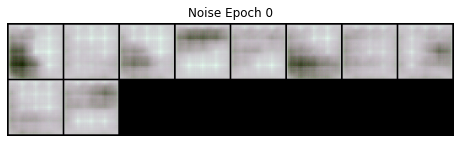

In [6]:
import matplotlib.pyplot as plt

# Create a new figure with specified size
fig = plt.figure(figsize=(8,8))

# Remove the axis
plt.axis("off")

# Set the title of the figure
plt.title('Noise Epoch 0')

# Create a list of images from the first epoch
# Each image is transposed to rearrange the dimensions from (channels, height, width) to (height, width, channels)
# This is done because plt.imshow expects the color channel to be the last dimension
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list[0:1]]

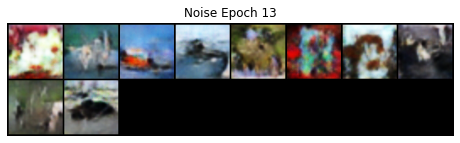

In [10]:
# Select the first 50 images from the list of generated images
tr = fakeimg_list[0:50]

# Create a new figure with specified size
fig = plt.figure(figsize=(8,8))

# Remove the axis
plt.axis("off")

# Set the title of the figure
plt.title('Noise Epoch 13')

# Create a list of images from the first 13 epochs
# Each image is transposed to rearrange the dimensions from (channels, height, width) to (height, width, channels)
# This is done because plt.imshow expects the color channel to be the last dimension
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in tr]

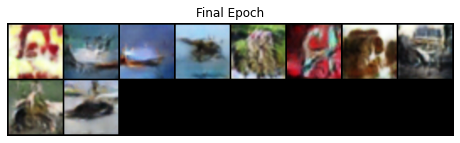

In [8]:
import matplotlib.pyplot as plt

# Create a new figure with specified size
fig = plt.figure(figsize=(8,8))

# Remove the axis
plt.axis("off")

# Set the title of the figure
plt.title('Final Epoch')

# Create a list of images from the final epoch
# Each image is transposed to rearrange the dimensions from (channels, height, width) to (height, width, channels)
# This is done because plt.imshow expects the color channel to be the last dimension
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list]

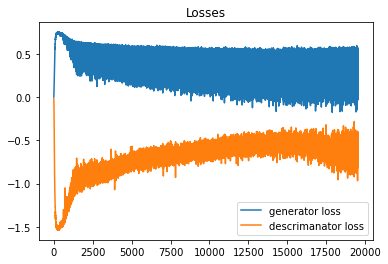

In [11]:
# Set the title of the plot
plt.title('Losses')

# Plot the generator loss
plt.plot(loss_ge,label = "generator loss")

# Plot the discriminator loss
plt.plot(loss_de,label = "discriminator loss")

# Add a legend to the plot
plt.legend()